In [1]:
# Calling the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay,r2_score
from sklearn.linear_model import LinearRegression
from lightgbm import  LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

### 1. Business Problem

Baseball players' salary information and career statistics for 1986 are shared. Develop a machine learning model to make salary predictions on this data set.

### 2. Dataset Story

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

### 3. Features

+ AtBat: Number of times at bat in 1986

+ Hits: Number of hits in 1986

+ HmRun: Number of home runs in 1986

+ Runs: Number of runs in 1986

+ RBI: Number of runs batted in in 1986

+ Walks: Number of walks in 1986

+ Years: Number of years in the major leagues

+ CAtBat: Number of times at bat during his career

+ CHits: Number of hits during his career

+ CHmRun: Number of home runs during his career

+ CRuns: Number of runs during his career

+ CRBI: Number of runs batted in during his career

+ CWalks: Number of walks during his career

+ League: A factor with levels A and N indicating player's league at the end of 1986

+ Division: A factor with levels E and W indicating player's division at the end of 1986

+ PutOuts: Number of put outs in 1986

+ Assists: Number of assists in 1986

+ Errors: Number of errors in 1986

+ Salary: 1987 annual salary on opening day in thousands of dollars

+ NewLeague: A factor with levels A and N indicating player's league at the beginning of 1987

### 4. Tasks

In [2]:
# Load the dataset
df = pd.read_csv("datasets/hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


##### 4.1 Exploratory Data Analysis(EDA)

In [3]:
def check_df(dataframe, head=5):
    print("######## Shape ########")
    print(dataframe.shape)
    print("######## Types ########")
    print(dataframe.dtypes)
    print("######## Head ########")
    print(dataframe.head())
    print("######## Tail ########")
    print((dataframe.tail()))
    print("######## NA ########")
    print(dataframe.isnull().sum())
    print("######## Quantiles ########")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

######## Shape ########
(322, 20)
######## Types ########
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
######## Head ########
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   C

In [4]:
# Capturing numeric and categorical variables

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

     It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
     Note: Categorical variables with numerical appearance are also included.

    Parameters
    ------
        dataframe: dataframe
                Dataframe from which variable names are to be taken
        cat_th: int, optional
                Class threshold value for variables that are numeric but categorical
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        inside num_but_cat cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [5]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [6]:
cat_cols

['League', 'Division', 'NewLeague']

In [7]:
num_cols

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'Salary']

In [8]:
cat_but_car

[]

In [9]:
# Analyze numerical and categorical variables.

In [10]:
###################################
# ANALYSIS OF CATEGORICAL VARIABLES
###################################

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
          "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

        League      Ratio
League                   
A          175  54.347826
N          147  45.652174
################


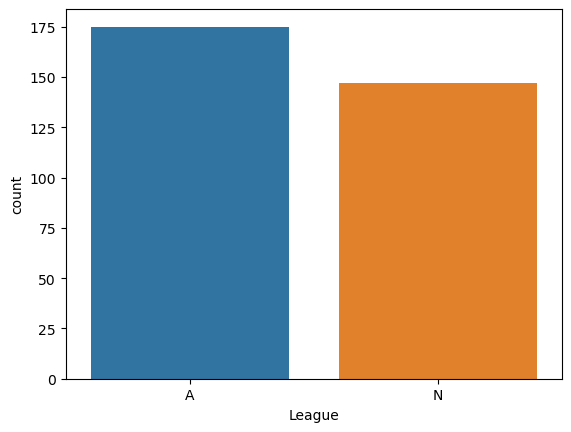

          Division      Ratio
Division                     
W              165  51.242236
E              157  48.757764
################


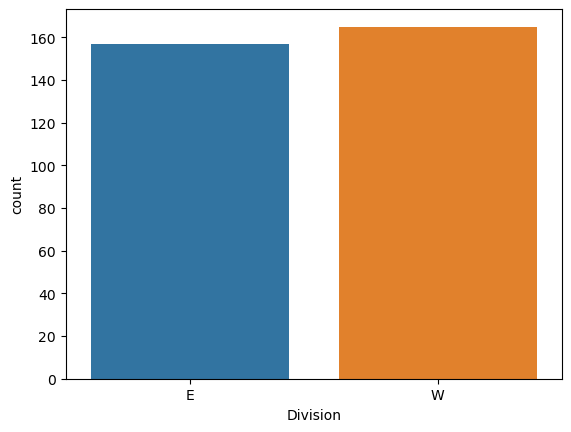

           NewLeague      Ratio
NewLeague                      
A                176  54.658385
N                146  45.341615
################


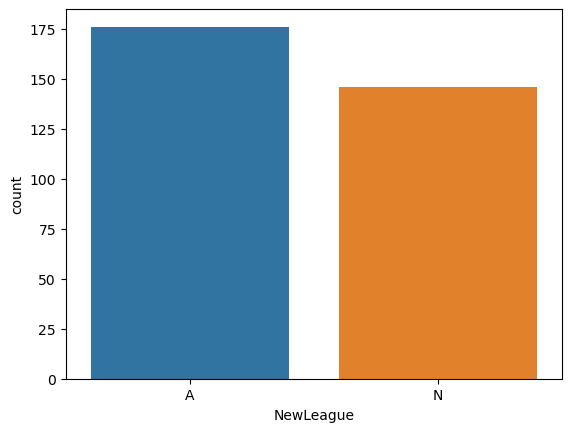

In [11]:
for col in cat_cols:
    cat_summary(df, col, True)

In [12]:
###################################
# ANALYSIS OF NUMERICAL VARIABLES
##################################

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    322.000000
mean     380.928571
std      153.404981
min       16.000000
5%       161.000000
10%      194.100000
20%      221.800000
30%      281.300000
40%      321.800000
50%      379.500000
60%      430.200000
70%      490.000000
80%      535.600000
90%      584.900000
95%      609.900000
99%      658.590000
max      687.000000
Name: AtBat, dtype: float64


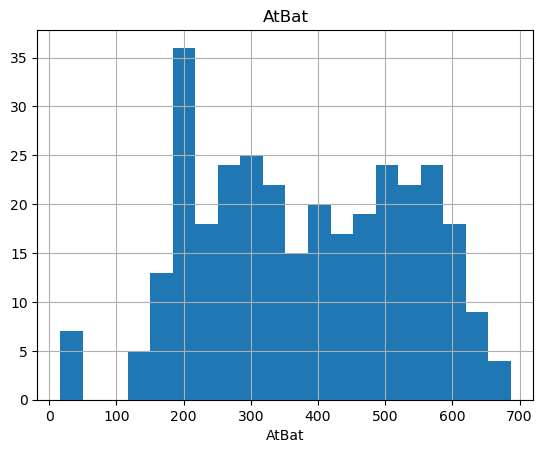

count    322.000000
mean     101.024845
std       46.454741
min        1.000000
5%        39.000000
10%       45.100000
20%       57.000000
30%       70.000000
40%       82.000000
50%       96.000000
60%      113.000000
70%      128.700000
80%      144.000000
90%      163.000000
95%      174.000000
99%      210.790000
max      238.000000
Name: Hits, dtype: float64


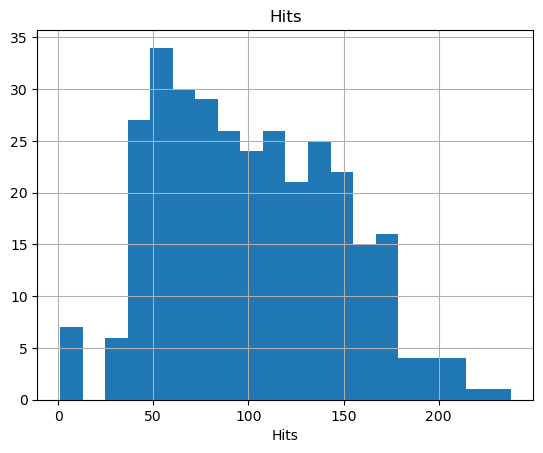

count    322.000000
mean      10.770186
std        8.709037
min        0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        5.000000
40%        6.000000
50%        8.000000
60%       10.600000
70%       14.000000
80%       18.000000
90%       24.000000
95%       28.950000
99%       33.000000
max       40.000000
Name: HmRun, dtype: float64


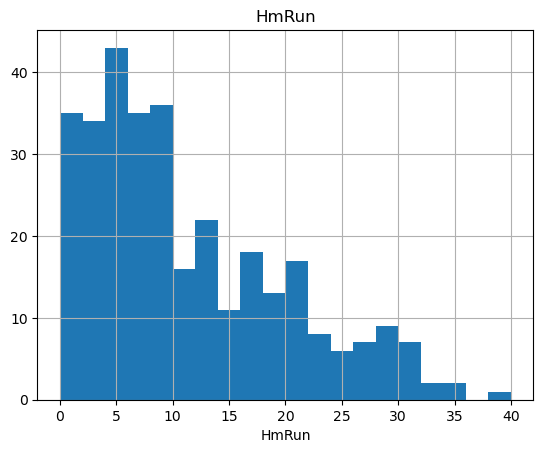

count    322.000000
mean      50.909938
std       26.024095
min        0.000000
5%        17.000000
10%       20.100000
20%       27.000000
30%       33.000000
40%       41.000000
50%       48.000000
60%       55.600000
70%       66.000000
80%       75.800000
90%       89.000000
95%       94.000000
99%      107.790000
max      130.000000
Name: Runs, dtype: float64


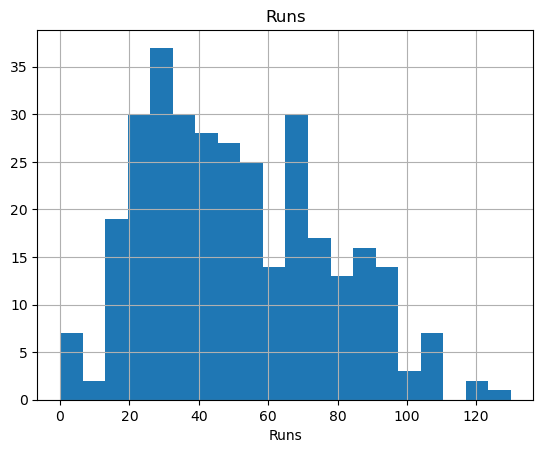

count    322.000000
mean      48.027950
std       26.166895
min        0.000000
5%        14.000000
10%       19.000000
20%       26.000000
30%       30.000000
40%       36.400000
50%       44.000000
60%       49.000000
70%       58.000000
80%       73.000000
90%       86.000000
95%       96.000000
99%      112.370000
max      121.000000
Name: RBI, dtype: float64


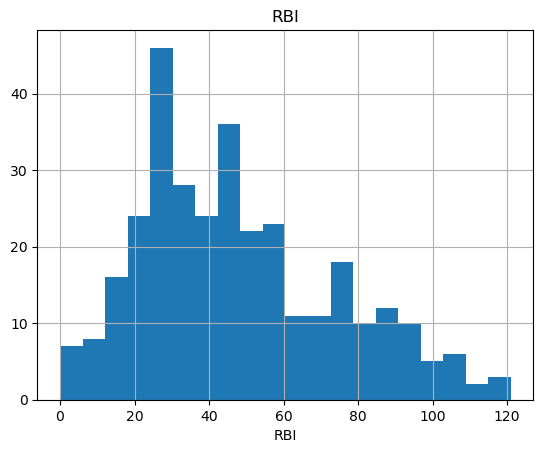

count    322.000000
mean      38.742236
std       21.639327
min        0.000000
5%        11.050000
10%       15.000000
20%       20.000000
30%       24.000000
40%       30.000000
50%       35.000000
60%       40.000000
70%       48.700000
80%       59.000000
90%       69.900000
95%       78.000000
99%       93.580000
max      105.000000
Name: Walks, dtype: float64


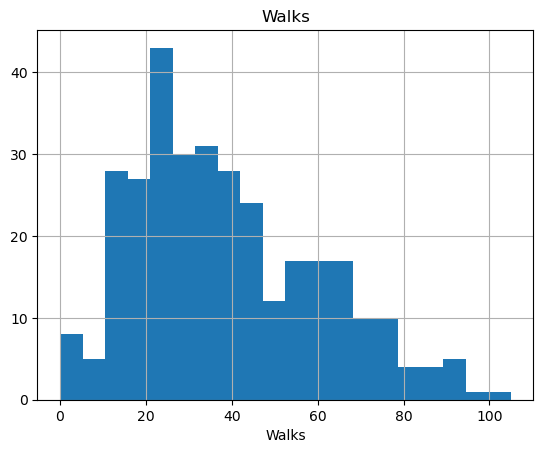

count    322.000000
mean       7.444099
std        4.926087
min        1.000000
5%         1.000000
10%        2.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        7.600000
70%       10.000000
80%       12.000000
90%       15.000000
95%       17.000000
99%       19.790000
max       24.000000
Name: Years, dtype: float64


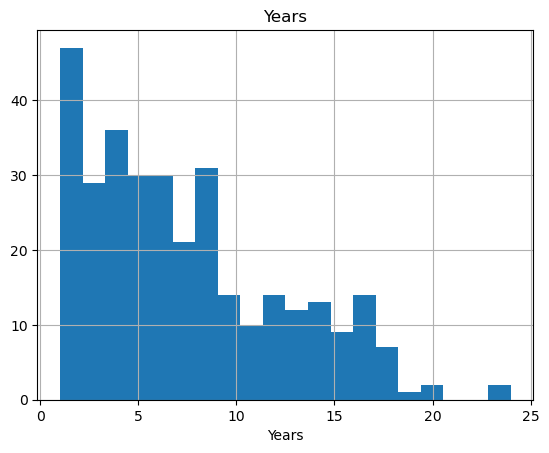

count      322.00000
mean      2648.68323
std       2324.20587
min         19.00000
5%         216.50000
10%        342.20000
20%        667.60000
30%        963.40000
40%       1402.20000
50%       1928.00000
60%       2654.00000
70%       3365.00000
80%       4483.00000
90%       6123.40000
95%       7125.60000
99%       8749.97000
max      14053.00000
Name: CAtBat, dtype: float64


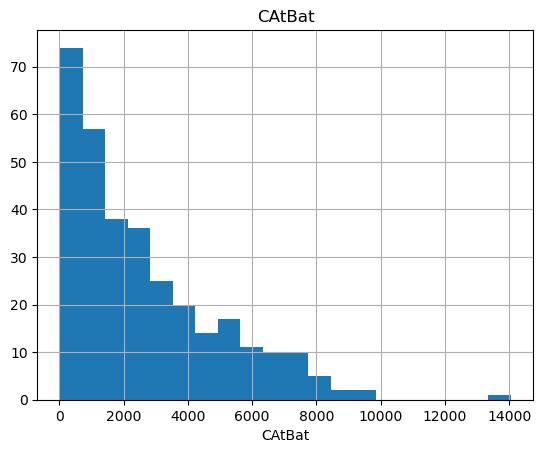

count     322.000000
mean      717.571429
std       654.472627
min         4.000000
5%         54.000000
10%        86.000000
20%       164.600000
30%       238.000000
40%       355.800000
50%       508.000000
60%       708.200000
70%       911.100000
80%      1229.200000
90%      1659.600000
95%      2017.150000
99%      2500.340000
max      4256.000000
Name: CHits, dtype: float64


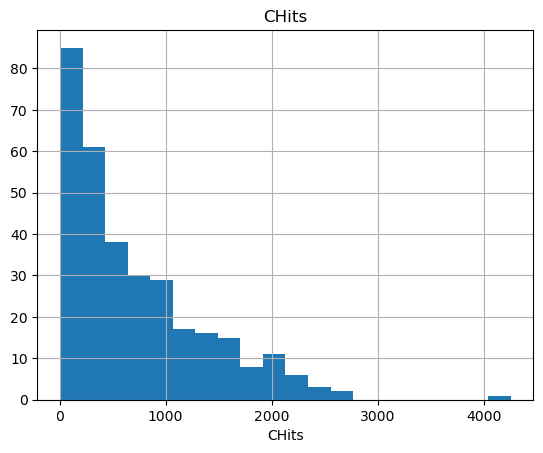

count    322.000000
mean      69.490683
std       86.266061
min        0.000000
5%         2.000000
10%        4.000000
20%       10.200000
30%       16.300000
40%       27.400000
50%       37.500000
60%       51.200000
70%       72.400000
80%      103.800000
90%      194.900000
95%      265.650000
99%      373.120000
max      548.000000
Name: CHmRun, dtype: float64


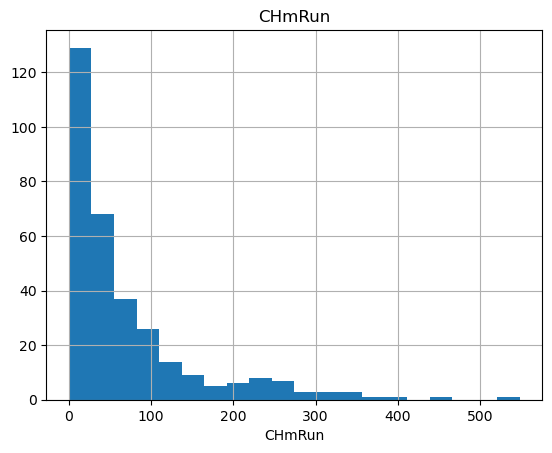

count     322.000000
mean      358.795031
std       334.105886
min         1.000000
5%         27.000000
10%        38.100000
20%        80.400000
30%       117.300000
40%       181.000000
50%       247.000000
60%       333.000000
70%       443.400000
80%       627.200000
90%       895.700000
95%      1032.300000
99%      1174.370000
max      2165.000000
Name: CRuns, dtype: float64


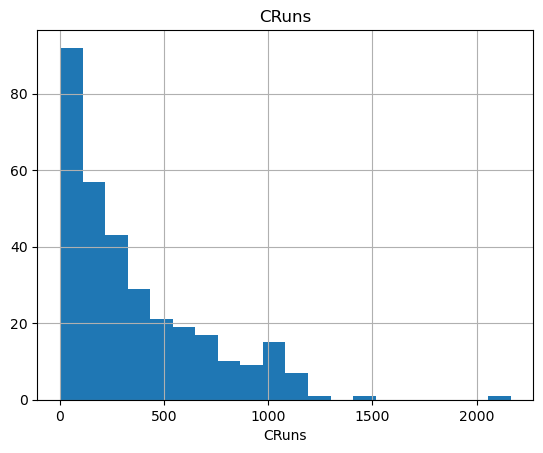

count     322.000000
mean      330.118012
std       333.219617
min         0.000000
5%         22.050000
10%        34.100000
20%        70.200000
30%       106.300000
40%       149.000000
50%       220.500000
60%       303.600000
70%       379.100000
80%       496.200000
90%       861.600000
95%      1071.750000
99%      1310.850000
max      1659.000000
Name: CRBI, dtype: float64


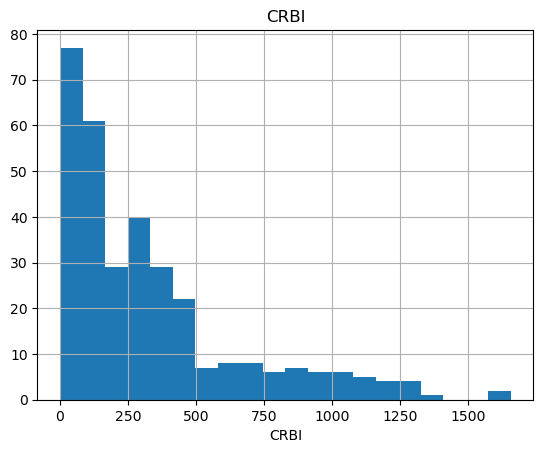

count     322.000000
mean      260.239130
std       267.058085
min         0.000000
5%         15.050000
10%        30.100000
20%        55.000000
30%        82.000000
40%       117.400000
50%       170.500000
60%       226.600000
70%       300.700000
80%       421.000000
90%       643.900000
95%       817.600000
99%      1139.140000
max      1566.000000
Name: CWalks, dtype: float64


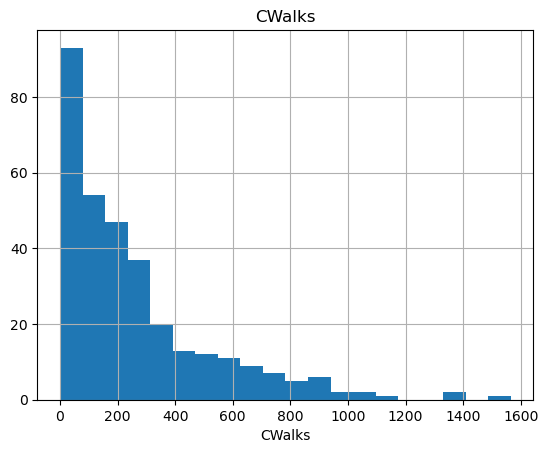

count     322.000000
mean      288.937888
std       280.704614
min         0.000000
5%         33.200000
10%        62.200000
20%        99.600000
30%       132.000000
40%       167.000000
50%       212.000000
60%       257.400000
70%       303.000000
80%       365.800000
90%       685.600000
95%       910.650000
99%      1301.190000
max      1378.000000
Name: PutOuts, dtype: float64


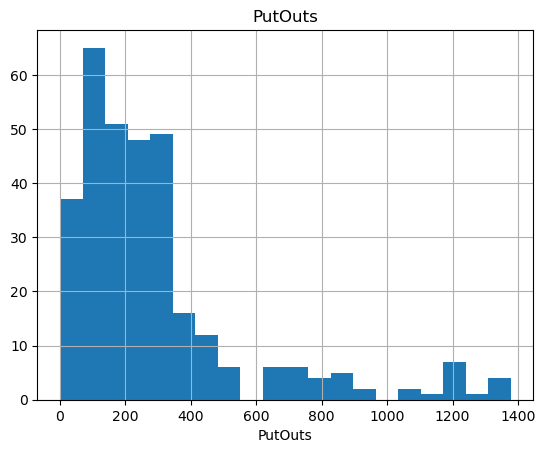

count    322.000000
mean     106.913043
std      136.854876
min        0.000000
5%         0.000000
10%        2.000000
20%        5.200000
30%        9.000000
40%       15.400000
50%       39.500000
60%       76.800000
70%      134.800000
80%      210.800000
90%      353.300000
95%      431.450000
99%      478.160000
max      492.000000
Name: Assists, dtype: float64


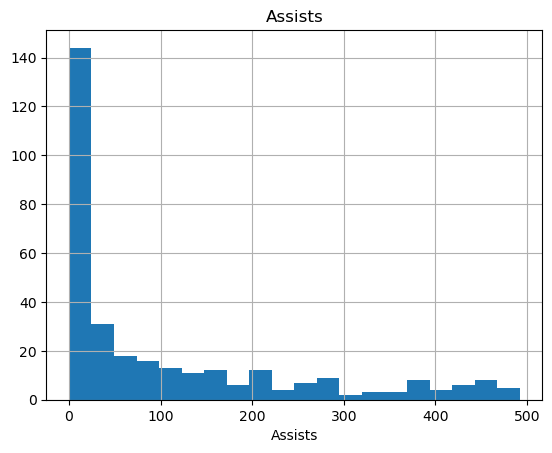

count    322.000000
mean       8.040373
std        6.368359
min        0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        8.000000
70%       10.000000
80%       13.000000
90%       17.000000
95%       20.000000
99%       25.790000
max       32.000000
Name: Errors, dtype: float64


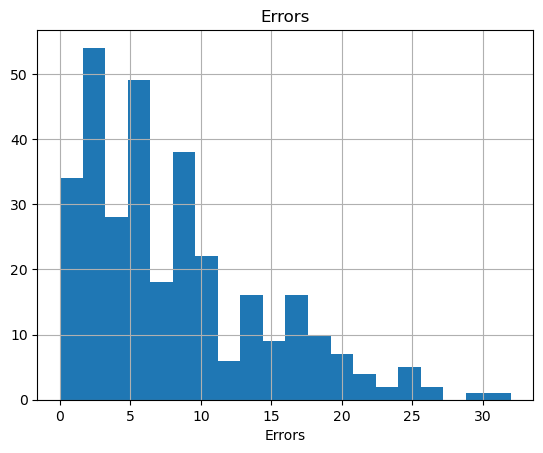

count     263.000000
mean      535.925882
std       451.118681
min        67.500000
5%         86.600000
10%       100.000000
20%       155.000000
30%       221.000000
40%       300.000000
50%       425.000000
60%       538.000000
70%       700.000000
80%       809.000000
90%      1048.666600
95%      1346.000000
99%      2032.886540
max      2460.000000
Name: Salary, dtype: float64


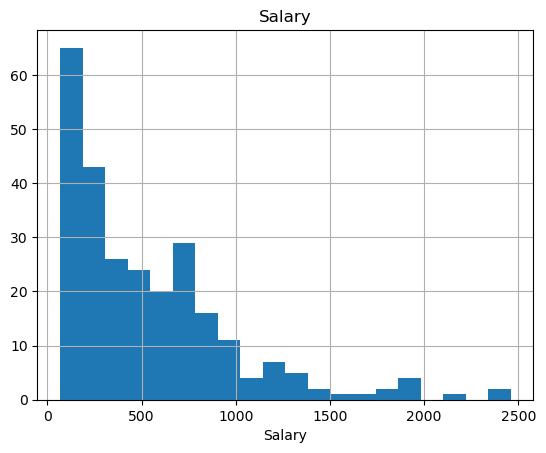

In [13]:
for col in num_cols:
    num_summary(df, col, True)

In [14]:
# Conduct target variable analysis.
# Target variable analysis according to categorical variables

def target_summary_with_cat(dataframe, target, col_name):
    print(pd.DataFrame({"Taget Mean": dataframe.groupby(col_name)[target].mean()}))


for col in cat_cols:
    target_summary_with_cat(df, "Salary",col)

        Taget Mean
League            
A       541.999547
N       529.117500
          Taget Mean
Division            
E         624.271364
W         450.876873
           Taget Mean
NewLeague            
A          537.113028
N          534.553852


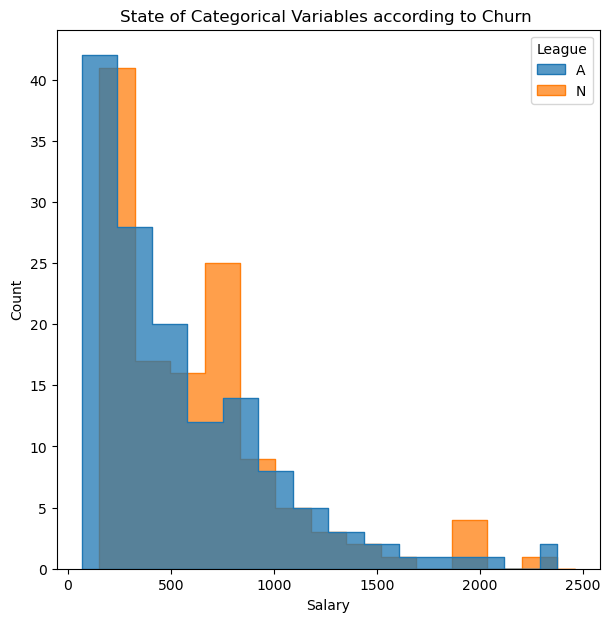

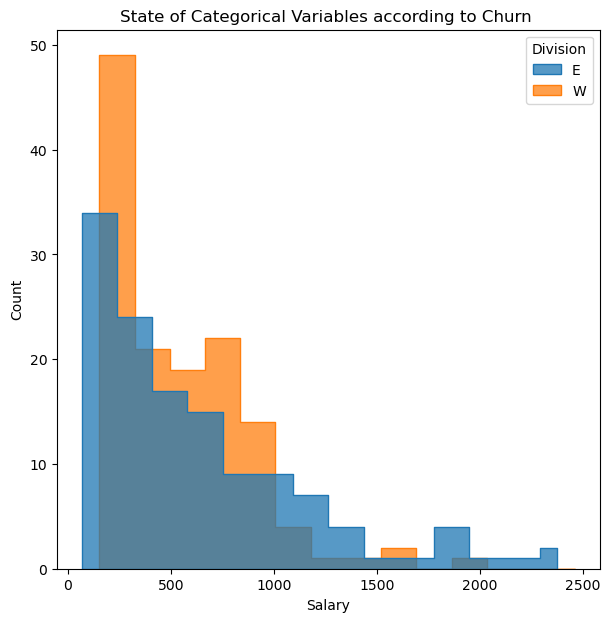

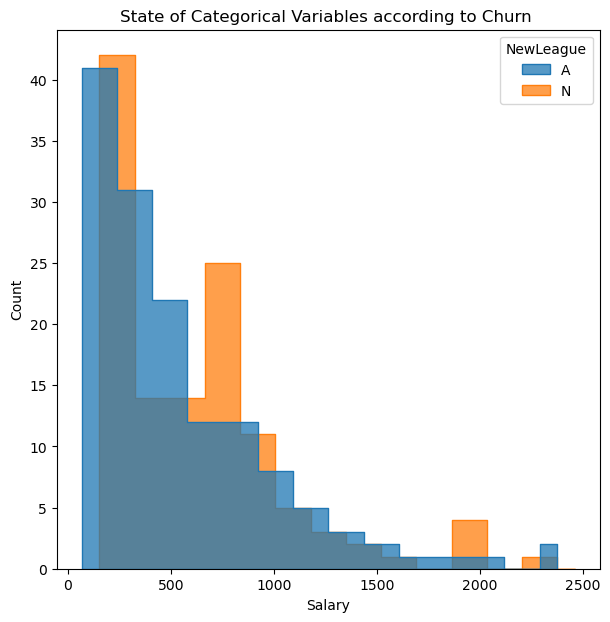

In [15]:
# Target variable analysis with graphs

def target_vs_category_visual(dataframe, target, col_name):
    plt.figure(figsize=(7,7))
    sns.histplot(x=target, hue=col_name, data=dataframe, element="step", multiple="dodge")
    plt.title("State of Categorical Variables according to Churn ")
    plt.show(block=True)


for col in cat_cols:
    target_vs_category_visual(df,"Salary", col)

In [16]:
# Target variable analysis according to numerical variables

def target_summary_with_num(dataframe, target, numeric_col):
    print(dataframe.groupby(target).agg({numeric_col: "mean"}),end="\n\n\n")


for col in num_cols:
    target_summary_with_num(df,"Salary", col)

          AtBat
Salary         
67.500    181.0
68.000    209.0
70.000    248.6
75.000    236.4
80.000    399.0
...         ...
1940.000  514.0
1975.000  677.0
2127.333   20.0
2412.500  618.0
2460.000  495.0

[150 rows x 1 columns]


           Hits
Salary         
67.500     41.0
68.000     54.0
70.000     57.4
75.000     58.2
80.000    102.0
...         ...
1940.000  144.0
1975.000  238.0
2127.333    1.0
2412.500  200.0
2460.000  151.0

[150 rows x 1 columns]


          HmRun
Salary         
67.500      1.0
68.000      3.0
70.000      3.2
75.000      3.0
80.000      3.0
...         ...
1940.000    0.0
1975.000   31.0
2127.333    0.0
2412.500   20.0
2460.000   17.0

[150 rows x 1 columns]


           Runs
Salary         
67.500     15.0
68.000     25.0
70.000     27.8
75.000     25.2
80.000     56.0
...         ...
1940.000   67.0
1975.000  117.0
2127.333    0.0
2412.500   98.0
2460.000   61.0

[150 rows x 1 columns]


            RBI
Salary         
67.500     21.0
68.000     14.0


###### 4.1.1 The Missing Values Analysis

In [17]:
# To find missing observations

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


na_cols = missing_values_table(df, na_name=True)

        n_miss  ratio
Salary      59  18.32


In [18]:
# Filling missing data with KNN method 
# The get_dummies method below allows us to express categorical variables with 2 or more classes numerically.
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True,dtype=int)

# Standardization of variables
scaler = RobustScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)

# Importing the KNN format (KNN implementation)
imputer = KNNImputer(n_neighbors=5)  # Model nesnesi oluşturuldu
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)

# Thanks to the code blocks above, we have filled the missing data based on estimation.
# However, in order to see which ones are filled, we first need to correct the standardized data (Standardization was done for the Age and Mouse variables)

dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)
df = dff

In [19]:
missing_values_table(df, True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

###### 4.1.2 Outliers Analysis

In [20]:
# Conduct an outlier observation analysis.
## First, the threshold value (threshold), upper and lower limits are determined.

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [21]:
## Then we questioned whether there were any outliers

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False

In [22]:
for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun True
Runs True
RBI True
Walks True
Years True
CAtBat True
CHits True
CHmRun True
CRuns True
CRBI True
CWalks True
PutOuts True
Assists True
Errors True
Salary True


In [23]:
# Suppression of found outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

num_cols = [col for col in num_cols if col not in ["Salary"]]

for col in num_cols:
    replace_with_thresholds(df,col)    

In [24]:
# If we want to check if there are still outliers after suppressing;

for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False


###### 4.1.3 Correlation Analysis

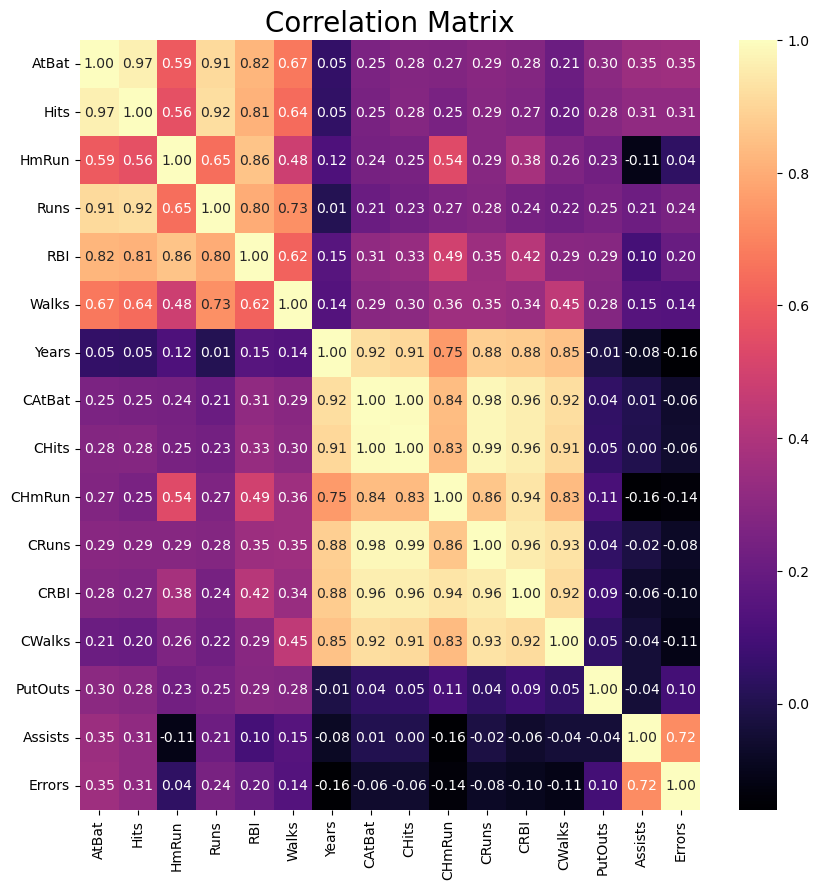

In [25]:
df[num_cols].corr()
f, ax = plt.subplots(figsize=[10,10])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

##### 4.2 Feature Engineering

###### 4.2.1 Create new variables

In [26]:
# We have added the player's career average number of kicks as a new variable
df["NEW_CATBAT"] = df["CAtBat"] / df["Years"]

In [27]:
# We have added the average of the player's most valuable hits during his career as a new variable
df["NEW_CHMRUN"] = df["CHmRun"] / df["Years"]

In [28]:
# Most valuable batting success rate per innings in 86-87
df["NEW_HMRUN_ATBAT"] = df["HmRun"] / df["AtBat"] * 100

In [29]:
# Ratio of points scored for his team in 86-87 to points scored throughout his career
df["NEW_RUN_RATE"] = df["Runs"] / df["CRuns"]

In [30]:
# The ratio of his field goals made in 86-87 to his field goals made during his career
df["NEW_HITS_RATE"] = df["Hits"] / df["CHits"]

In [31]:
# Since we added new variables, grab_col_names is called again

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 25
cat_cols: 3
num_cols: 22
cat_but_car: 0
num_but_cat: 3


###### 4.2.2 Encoding Operations

In [32]:
# Label Encoder

def label_encoder(dataframe, binary_col):
    label_encoder = LabelEncoder()
    dataframe[binary_col] = label_encoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_col = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]


for col in binary_col:
    label_encoder(df, col)

In [33]:
# One-hot Encoder

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe


cat_cols = [col for col in cat_cols if col not in binary_col and col not in ["Outcome"]]

df = one_hot_encoder(df, cat_cols, drop_first=True)

###### 4.2.3 Standardize for numeric variables

In [34]:
num_cols = [col for col in num_cols if "Salary" not in col]

ss = StandardScaler()
df[num_cols] = ss.fit_transform(df[num_cols])

##### 4.3 Modelling

In [35]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [37]:
# Modeling with Linear Regression
reg_model = LinearRegression().fit(X_train, y_train)

In [38]:
# Evaluation of prediction success for Train set
y_pred = reg_model.predict(X_train)

In [39]:
# RMSE
train_RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
train_RMSE

235.63360531759162

In [40]:
# R-square (Percentage of independent variables explaining the dependent variable)

train_r2 = reg_model.score(X_train, y_train)
train_r2

0.6505097595899922

In [41]:
# Evaluation of prediction success for the test set
y_pred = reg_model.predict(X_test)

In [42]:
# RMSE
test_RMSE_ = np.sqrt(mean_squared_error(y_test, y_pred))
test_RMSE_

311.8418999120233

In [43]:
# R-square (Percentage of independent variables explaining the dependent variable)
test_r2_ = reg_model.score(X_test, y_test)
test_r2_

0.5995982192683804

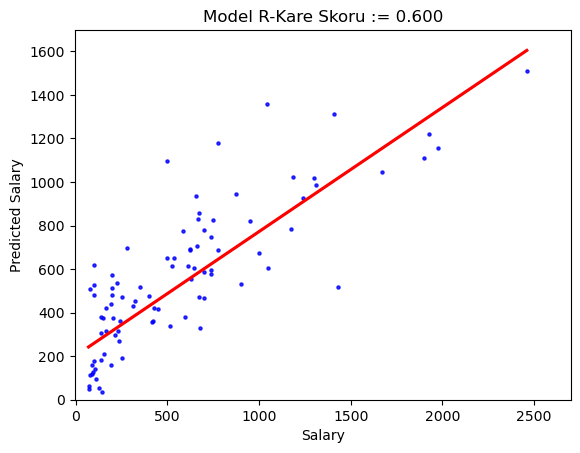

In [44]:
# Visualization of the Model

g = sns.regplot(x=y_test, y=y_pred, scatter_kws={"color": "b", "s": 5}, ci=False, color="r")
g.set_title(f"Model R-Kare Skoru := {reg_model.score(X_test, y_test):.3f}")
g.set_ylabel("Predicted Salary")
g.set_xlabel("Salary")
plt.xlim(-5, 2700)
plt.ylim(bottom=0)
plt.show()

In [45]:
# 10-Fold Cross-Validation
np.mean(np.sqrt(-cross_val_score(reg_model, X_train, y_train, cv=10, scoring="neg_mean_squared_error")))

267.5007861432544

In [46]:
# Modeling with Light Gradient Boosting - LightGBM 
lgb_model = LGBMRegressor(verbose=-1).fit(X_train, y_train)

In [47]:
# Train Error
y_pred = lgb_model.predict(X_train)

In [48]:
# Test Error
y_pred1 = lgb_model.predict(X_test)
lightgbm_train_rmse =np.sqrt(mean_squared_error(y_train, y_pred))
lightgbm_test_rmse=np.sqrt(mean_squared_error(y_test, y_pred1))
lightgbm_train_r2 = r2_score(y_train, y_pred)
lightgbm_test_r2 = r2_score(y_test, y_pred1)

print("LGBM Train RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_train, y_pred))), "\n")
print("LGBM Test RMSE:", "{:,.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred1))),"\n")
print("LGBM Train R^2:", "{:,.2f}".format(r2_score(y_train, y_pred)),"\n")
print("LGBM Test R^2:", "{:,.2f}".format(r2_score(y_test, y_pred1)))

LGBM Train RMSE: 115.13 

LGBM Test RMSE: 290.92 

LGBM Train R^2: 0.92 

LGBM Test R^2: 0.65


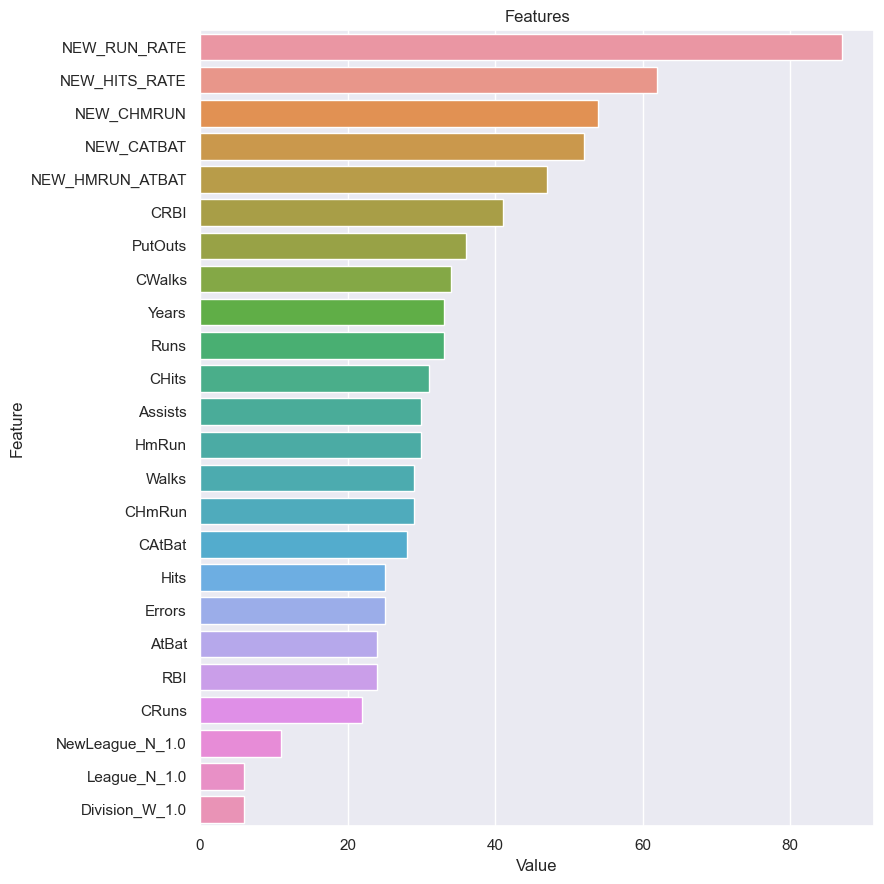

In [49]:
# Feature Importance

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(lgb_model, X_test)

In [50]:
# Hyperparameter Optimization
lgb_model.get_params()

lgb_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}


lgb_best_grid = GridSearchCV(lgb_model, lgb_params, cv=5, n_jobs=-1, verbose=False).fit(X_train,y_train)

final_model = lgb_model.set_params(**lgb_best_grid.best_params_).fit(X_train,y_train)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
rmse

330.17085009615414

In [51]:
final_test_r2 = final_model.score(X_test, y_test)
final_test_r2

0.6312500932377945

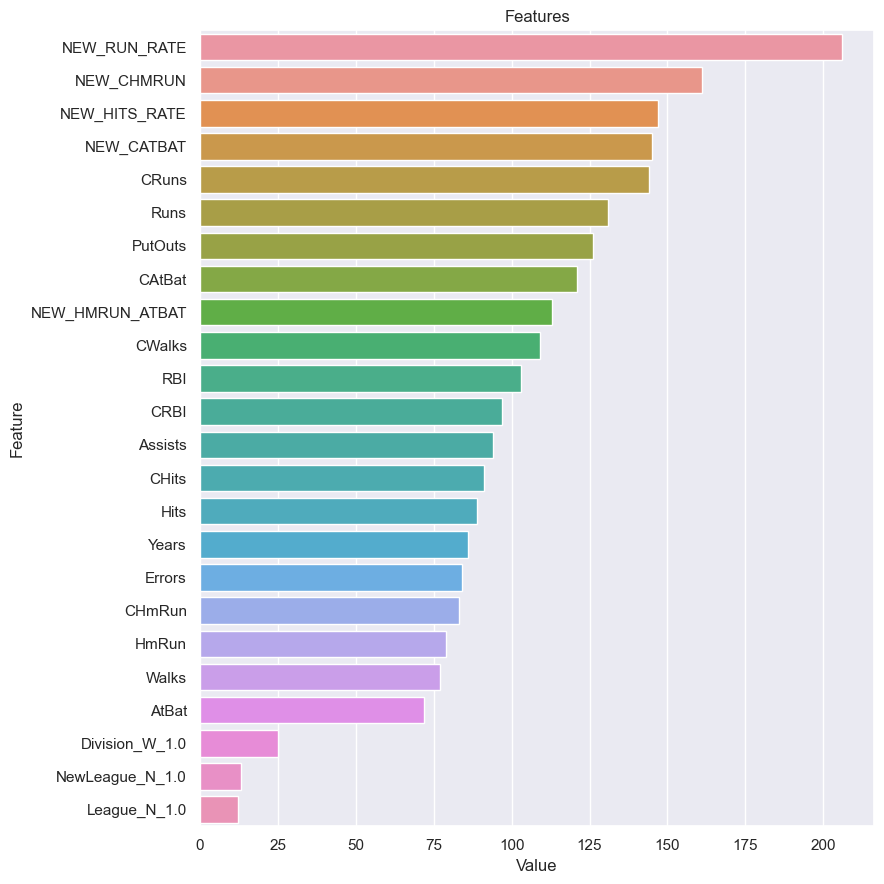

In [52]:
# Featue Importance
##########################
def plot_importance(model, features, num=50, save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show(block = True)
    if save:
        plt.savefig("importances.png")



plot_importance(final_model, X_test)

In [53]:
# Modeling with RandomForest
rf_model = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf_model.predict(X_train)

In [54]:
# Evaluation of prediction success for Train set
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
train_rmse

109.48549559779548

In [55]:
train_r2 = rf_model.score(X_train, y_train)
train_r2

0.9245474758188815

In [56]:
# Evaluation of prediction success for the test set
y_pred = rf_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_rmse

302.53143264207483

In [57]:
test_r2 = rf_model.score(X_test, y_test)
test_r2

0.6231503877270295

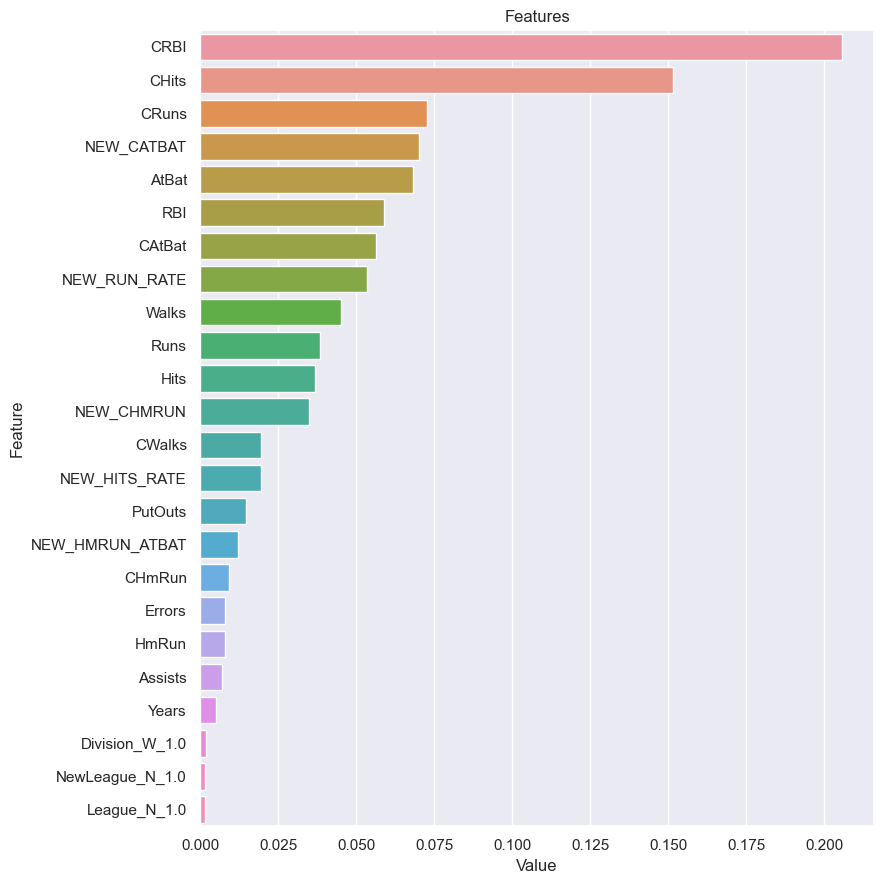

In [58]:
# Feature Importance

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_test)

In [58]:
# Hyperparameter Optimization

rf_model.get_params()

rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 15],
             "n_estimators": [100, 200, 500],
             "min_samples_split": [2, 5, 8]}


rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X_train,y_train)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_).fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [59]:
rf_final_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rf_final_test_rmse

309.0789215357915

In [60]:
rf_final_test_r2 = rf_final.score(X_test, y_test)
rf_final_test_r2

0.6066620579756961

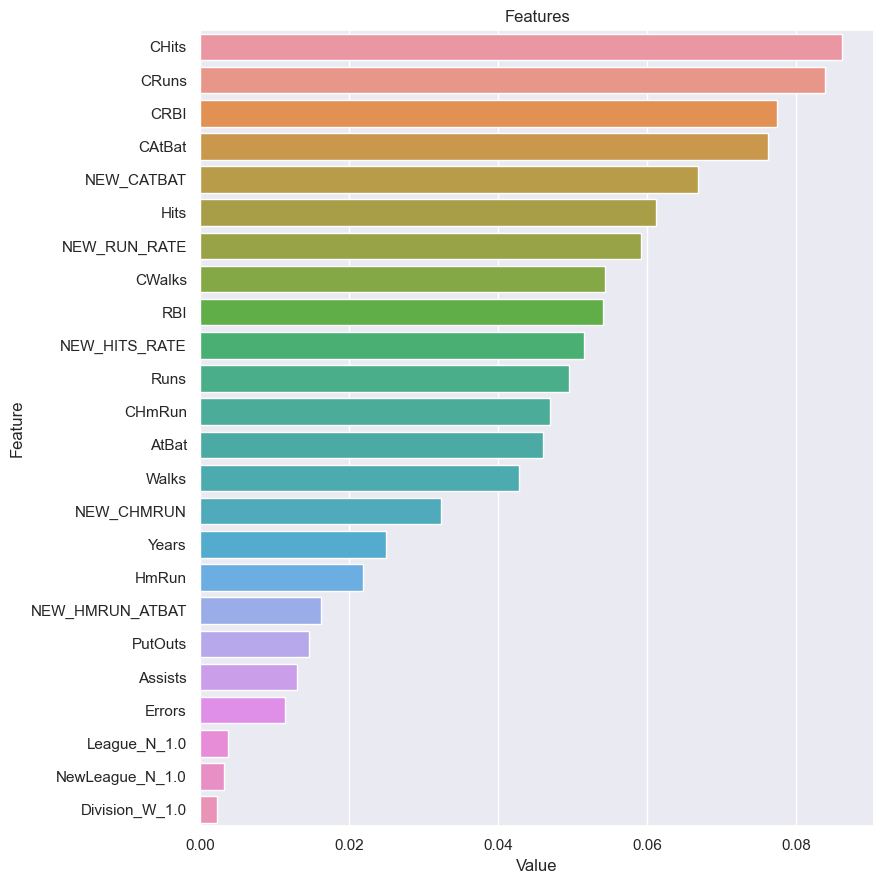

In [61]:
# Feature Importance

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_final, X_test)

### Summary

First of all, the necessary libraries were imported. Then, an overview of the data set and the structure of the variables were analyzed. In addition, a detailed examination was conducted with target variable analysis. We observed the missing data with EDA and filled it with KNN. We also performed outlier analysis for outlier observations. After new variables were created, coding analysis was performed for categorical variables. A machine learning model was built on the dataset; RMSE (Root Mean Square Error) and R-squared values were calculated using Linear Regression, LightGBM and Random Forest models. Feature importance analysis was applied to LightGBM and Random Forest models, allowing us to have an idea about which features are more effective. Finally, we applied the Random Forest model and hyperparameter optimization for LGBM to find the best parameter values. As a result, we see that the Random Froest model shows the best performance in terms of rmse error value.